In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import os
from pyTNG import data_interface as _data_interface
from pyTNG.cosmology import TNGcosmo
import illustris_python as il
import pyTNG.utils as utils

# Do not show warning in the output
import warnings
warnings.filterwarnings('ignore')

# display all outputs without having to inclue a print statement
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# make screen wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Reduced Hubble in TNG
h =TNGcosmo.h

In [4]:

def get_sim():
    basepath = "/virgotng/universe/IllustrisTNG/"
    sim_name = "L35n2160TNG"
    sim = _data_interface.TNG50Simulation(os.path.join(basepath, sim_name))
    sim_path = os.path.join(basepath, sim_name, "output")
    return sim, sim_path

In [5]:
def get_dataset_df(sim, snap_num):
    dataset = next(sim.group_cat[snap_num].chunk_generator("halo"))
    keys_needed = [
        "GroupMass",
        "GroupMassType"
    ]
    sub_dict = {key: dataset[key] for key in keys_needed}
    dataset_df = utils.dfFromArrDict(sub_dict)
    return dataset_df


In [6]:
def reduce_df(df):
    filt = (df[("GroupMassType", 4)] * 1e10 / h > 5e5)
    reduced_df = df[filt]

    new_df = pd.DataFrame().assign(
        M_halo=reduced_df[("GroupMass", 0)]* 1e10 / h,
        M_star=reduced_df[("GroupMassType", 4)]* 1e10 / h,
    )
    return new_df

In [7]:
def get_snap(snap_num):
    if snap_num < 10:
        return f"sn00{snap_num}"
    else:
        return f"sn0{snap_num}"

In [8]:
def build_snap_dfs(snap_num, save_name="df", base="/u/ivkos/analysis/dfs/all_tng_halos"):
    sim, simpath = get_sim()
    full_df = get_dataset_df(sim, snap_num=snap_num)
    save_df = reduce_df(full_df)
    snap = get_snap(snap_num)
    snap_path = os.path.join(base, snap)
    if not os.path.exists(snap_path):
        print(f"Creating directory '{snap_path}' as it does not exist yet.")
        os.system(f"mkdir {snap_path}")
    save_path = os.path.join(snap_path, "0_" + save_name + ".pickle")
    save_df.to_pickle(save_path)
    return

In [40]:
def get_halos_per_mass_bin(edges, snap, base="/u/ivkos/analysis/dfs/all_tng_halos"):
    df_path = os.path.join(base, snap, "0_df.pickle")
    df = pd.read_pickle(df_path)
    df["M_star"] = np.log10(df["M_star"])
    element_numbers  = []
    for i in range(len(edges)-1):
        elements = len(df[(df['M_star']>edges[i]) & (df['M_star']<edges[i+1])])
        element_numbers.append(elements)
    return np.array(element_numbers)

In [71]:
def plot_parameters(params):
    parameters = {}
    parameters["x_labelsize"] = 50
    parameters["y_labelsize"] = 50

    parameters["length_major_ticks"] = 16
    parameters["length_minor_ticks"] = 8
    parameters["width_minor_ticks"] = 3
    parameters["width_major_ticks"] = 4
    parameters["labelsize_x_ticks"] = 35
    parameters["labelsize_y_ticks"] = 35

    parameters["colorbar_labelsize"] = 50
    parameters["colorbar_ticklabelsize"] = 35

    parameters["axis_width"] = 3

    parameters["figure_width"] = 20
    parameters["figure_height"] = 15

    parameters["x_label"] = "$M_{\star} [\log(M_{\u2609})]$"
    parameters["y_label"] = "Number of halos"
    parameters["y_label_2"] = "Fraction of TNG halos"

    parameters["x_lim_min"] = 6.0
    parameters["x_lim_max"] = 8.3

    parameters["legendsize"] = 35

    parameters["narrowing_factor"] = 4 # For setting the bar width in the plot

    if params != None:
        for element in params:
            parameters[element] = params[element]
    return parameters


In [78]:
def set_ax_parameters(parameters, ax, ax2):
    ax.set_xlabel(parameters["x_label"], fontsize=parameters["x_labelsize"])
    ax.set_ylabel(parameters["y_label"], fontsize=parameters["y_labelsize"])
    ax2.set_ylabel(parameters["y_label_2"], fontsize=parameters["y_labelsize"])
    ax.tick_params(length=parameters["length_major_ticks"], width=parameters["width_major_ticks"])
    ax.tick_params(length=parameters["length_minor_ticks"], width=parameters["width_minor_ticks"], which='minor')
    ax.legend(fontsize = parameters["legendsize"])
    return

In [73]:
def set_plt_parameters(parameters):
    plt.rc('xtick', labelsize=parameters["labelsize_x_ticks"]) 
    plt.rc('ytick', labelsize=parameters["labelsize_y_ticks"]) 
    plt.rcParams["figure.figsize"] = (parameters["figure_width"], parameters["figure_height"])
    plt.rc('axes', linewidth=parameters["axis_width"])
    return


In [74]:
def z_to_snap(z):
    z_to_snap_dict = {6:"sn013", 8:"sn008", 13:"sn013"}
    return z_to_snap_dict[z]

In [79]:
def count_histogram(df, bins=16, params=None, save=False):
    
    parameters = plot_parameters(params)
    
    set_plt_parameters(parameters)
    
    df_z6 = df[df.z==6]
    df_z8 = df[df.z==8]
    df_z10 = df[df.z==10]

    log_masses_z6 = np.log10(df_z6['StarMass'])
    log_masses_z8 = np.log10(df_z8['StarMass'])
    log_masses_z10 = np.log10(df_z10['StarMass'])

    edges = np.linspace(parameters["x_lim_min"], parameters["x_lim_max"], bins)
    hist_z6, _ = np.histogram(log_masses_z6, bins=edges)
    hist_z8, _ = np.histogram(log_masses_z8, bins=edges)
    hist_z10, _ = np.histogram(log_masses_z10, bins=edges)

    haloes_per_bin_z6 = get_halos_per_mass_bin(edges, "sn013")
    haloes_per_bin_z8 = get_halos_per_mass_bin(edges, "sn008")
    haloes_per_bin_z10 = get_halos_per_mass_bin(edges, "sn004")
    
    centers = (edges[1:]+edges[:-1])/2
    binning_width = edges[1]-edges[0]
    bar_width = binning_width/parameters["narrowing_factor"]

    f, ax = plt.subplots()
    masses = [log_masses_z6, log_masses_z8, log_masses_z10]
    labels = ['z=6','z=8','z=10']
    ax.bar(centers-bar_width, hist_z6, width = bar_width, label="z=6", alpha=0.7)
    ax.bar(centers, hist_z8, width = bar_width, label="z=8", alpha=0.7)
    ax.bar(centers+bar_width, hist_z10, width = bar_width, label="z=10", alpha=0.7)
    ax2 = ax.twinx()
    # 
    ax2.bar(centers-bar_width, hist_z6/haloes_per_bin_z6, width = bar_width, alpha=0.3, color='black')
    ax2.bar(centers, hist_z8/haloes_per_bin_z8, width = bar_width, alpha=0.3, color='black')
    ax2.bar(centers+bar_width, hist_z10/haloes_per_bin_z10, width = bar_width, alpha=0.3, color='black')

    set_ax_parameters(parameters, ax, ax2)
    
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/halo_counts.pdf', bbox_inches = 'tight')
    return

In [76]:
def plot_scatter(df, save=False):
    
    x_label = '$M_{\star}[\log(M_{\u2609})]$'
    y_label = '$\log(Q_{0})[\mathrm{s}^{-1}]$'
    
    h = 0.6774
    lower_bound = 5.7
    upper_bound = 9.3
    narrowing_factor = 4.5 # For setting the bar width in the plot
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 15

    df_z6 = df[df.z==6]
    df_z8 = df[df.z==8]
    df_z10 = df[df.z==10]

    _ = plt.scatter(np.log10(df_z6['StarMass']), np.log10(df_z6['Q0']), label='z=6')
    _ = plt.scatter(np.log10(df_z8['StarMass']), np.log10(df_z8['Q0']), label='z=8')
    _ = plt.scatter(np.log10(df_z10['StarMass']), np.log10(df_z10['Q0']), label='z=10')

    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    plt.xlabel(x_label, fontsize=labelsize)
    plt.ylabel(y_label, fontsize=labelsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    plt.legend(fontsize = legendsize)
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/all_data_scatter.pdf', bbox_inches = 'tight')
    return

In [27]:
def update_df(df):
    h = 0.6774
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    return

In [28]:
df = pd.read_pickle('dfs/esc_analysis.pickle')
update_df(df)

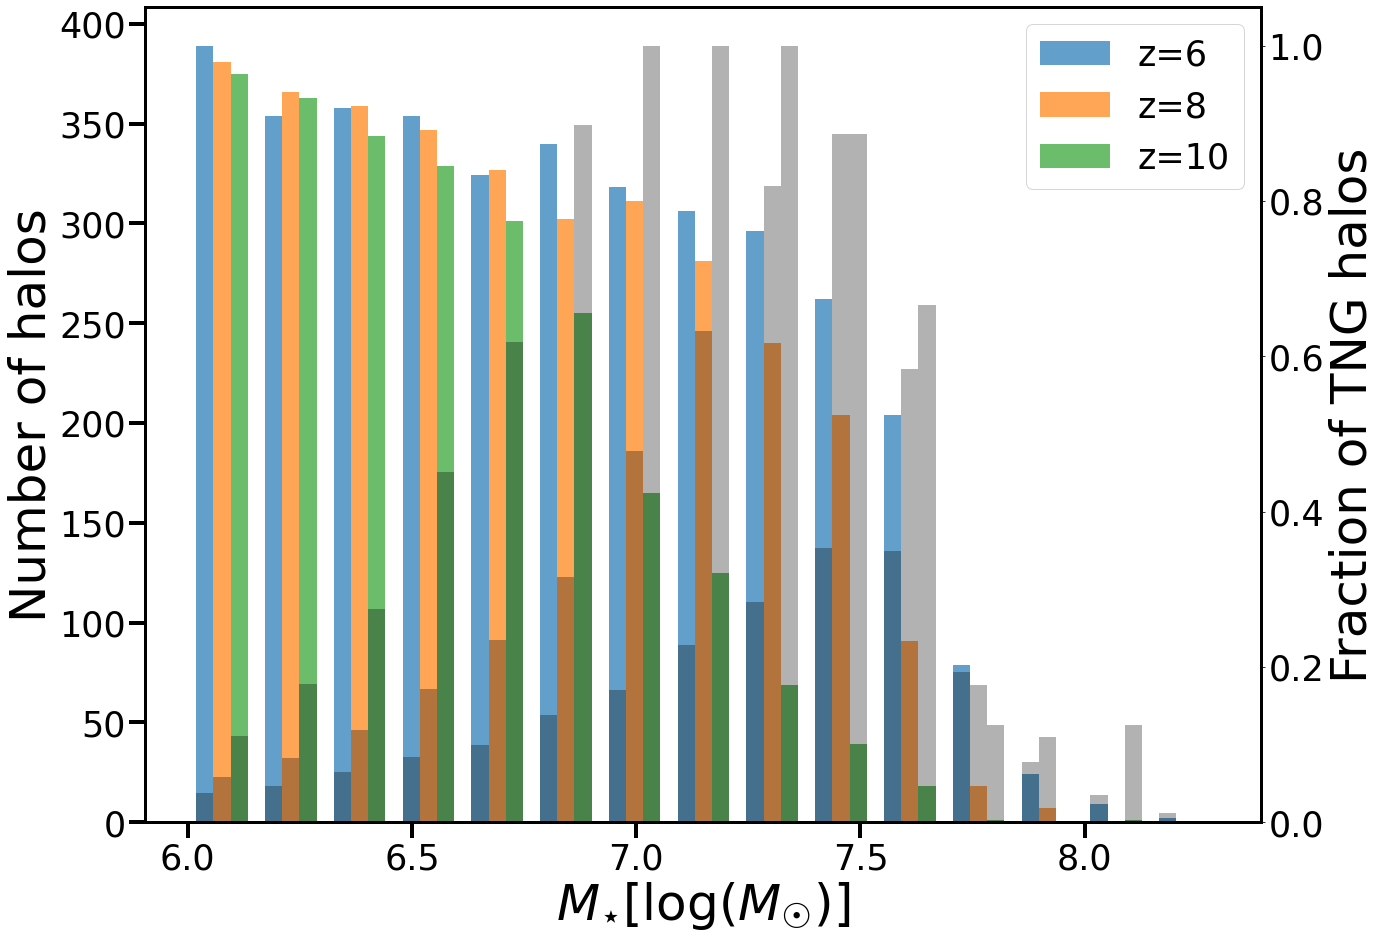

In [80]:
count_histogram(df, save=True)

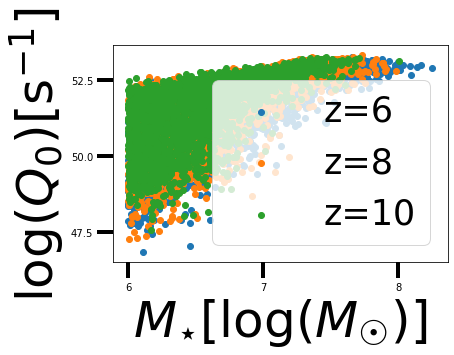

In [6]:
plot_scatter(df, save=True)

NameError: name 'df' is not defined